In [86]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot
#os.chdir('C:/Users/user/Desktop/Yash/CReST/Files/Correlation')
formosa = pd.read_csv('Without_Errors.csv', index_col = 'TagName')
series = formosa.iloc[:500,1]
series.head()

TagName
2017-10-12 00:00:00    4.603224
2017-10-12 00:05:00    4.585253
2017-10-12 00:10:00    4.581443
2017-10-12 00:15:00    4.591214
2017-10-12 00:20:00    4.593621
Name: MLEGP_1A_PIC_4120.PV, dtype: float64

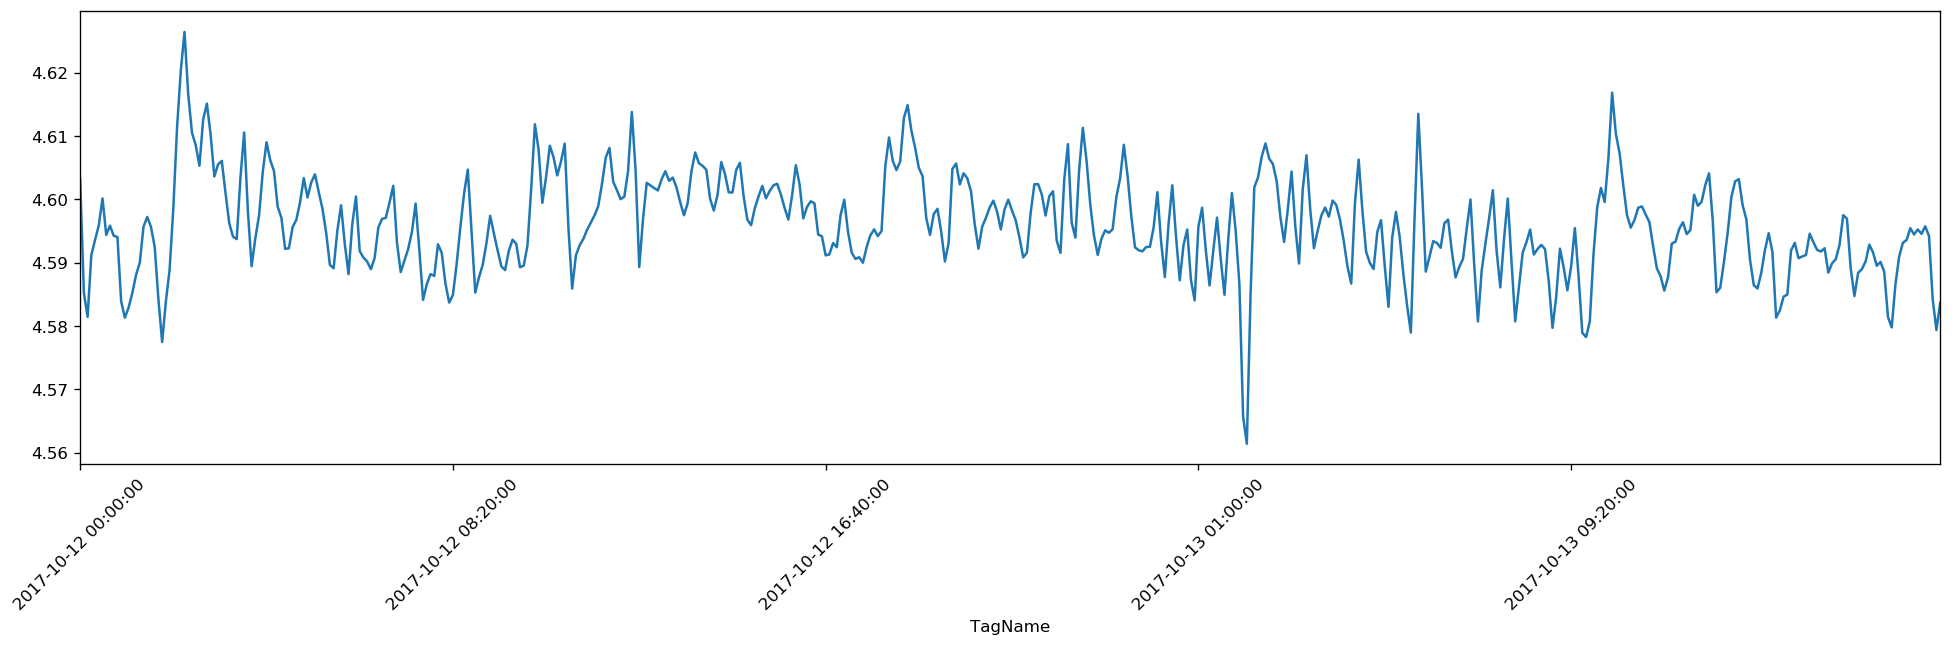

In [87]:
pyplot.figure(figsize = [20,5])
series.plot()
pyplot.xticks(rotation=45)
pyplot.show()


In [88]:
# determine the 

# check if the time series is stationary 
The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

Why?

Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

Reference 
[1]. https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [89]:
df = series
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.069228
p-value: 0.000000


The p-value is 0 so we don't have to compute the the value of 'd'

# how to determine q:
Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

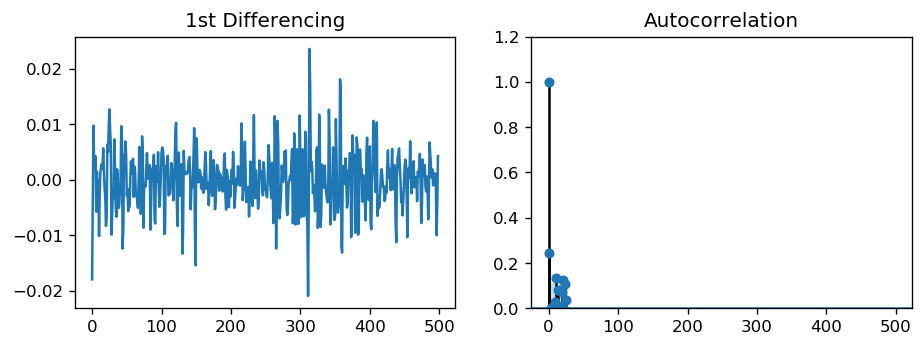

In [90]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(df.values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(np.diff(df.values), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 1. When in doubt, go with the simpler model that sufficiently explains the Y.

# p determination


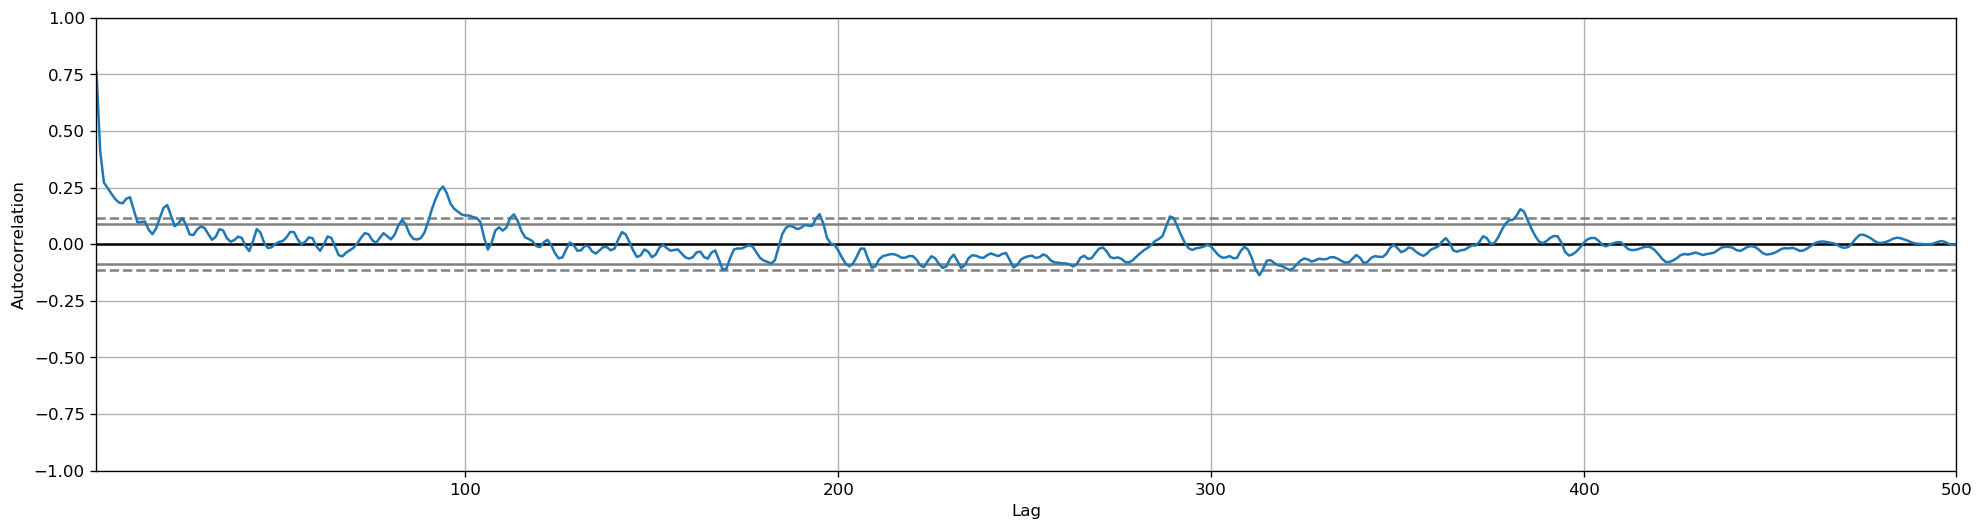

In [91]:

from pandas.plotting import autocorrelation_plot
pyplot.figure(figsize = [20,5]) 
autocorrelation_plot(series)
pyplot.show()

/Users/sumitpandey/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  % freq, ValueWarning)


                               ARMA Model Results                               
Dep. Variable:     MLEGP_1A_PIC_4120.PV   No. Observations:                  300
Model:                      ARMA(10, 1)   Log Likelihood                1250.074
Method:                         css-mle   S.D. of innovations              0.004
Date:                  Sat, 04 Apr 2020   AIC                          -2474.147
Time:                          22:04:26   BIC                          -2425.998
Sample:                      10-12-2017   HQIC                         -2454.878
                           - 10-13-2017                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           4.5977      0.001   3831.208      0.000       4.595       4.600
ar.L1.MLEGP_1A_PIC_4120.PV      0.6041      0.785      0.770    

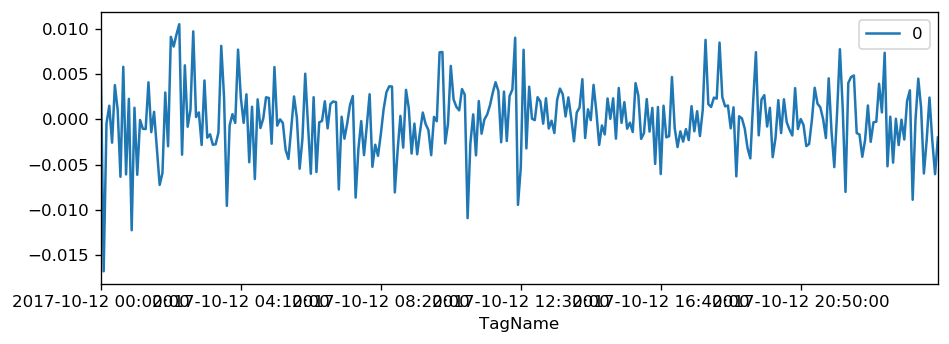

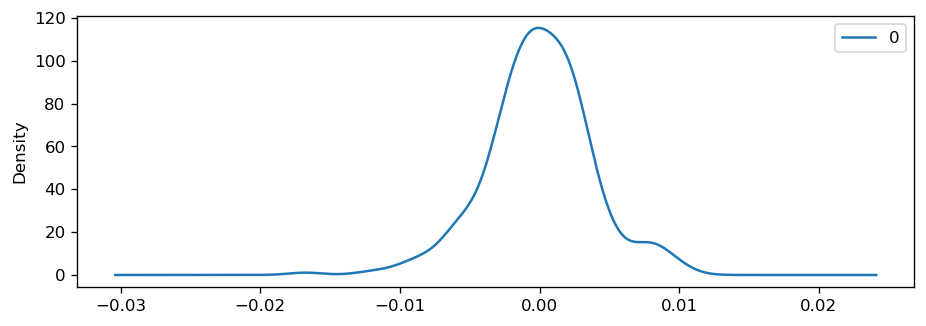

                0
count  300.000000
mean    -0.000016
std      0.003794
min     -0.016758
25%     -0.002135
50%     -0.000027
75%      0.002262
max      0.010484


In [92]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(series.iloc[:300,], order=(10,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [93]:
X = series.values
size = int(len(X) * 0.60)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('for ',t, ': ','predicted=%f, expected=%f' % (yhat, obs))


for  0 :  predicted=4.588012, expected=4.595673
for  1 :  predicted=4.600904, expected=4.598693
for  2 :  predicted=4.593167, expected=4.591949
for  3 :  predicted=4.590455, expected=4.586403
for  4 :  predicted=4.587500, expected=4.591925
for  5 :  predicted=4.595674, expected=4.597134
for  6 :  predicted=4.594853, expected=4.590561
for  7 :  predicted=4.586723, expected=4.584929
for  8 :  predicted=4.587354, expected=4.593602
for  9 :  predicted=4.598606, expected=4.601012
for  10 :  predicted=4.597804, expected=4.595054
for  11 :  predicted=4.590052, expected=4.586627
for  12 :  predicted=4.587613, expected=4.565671
for  13 :  predicted=4.560527, expected=4.561400
for  14 :  predicted=4.573367, expected=4.585029
for  15 :  predicted=4.597119, expected=4.601916
for  16 :  predicted=4.598048, expected=4.603480
for  17 :  predicted=4.597732, expected=4.606788
for  18 :  predicted=4.605759, expected=4.608839
for  19 :  predicted=4.602764, expected=4.606450
for  20 :  predicted=4.600488,

for  167 :  predicted=4.592419, expected=4.591769
for  168 :  predicted=4.591218, expected=4.592296
for  169 :  predicted=4.593083, expected=4.588443
for  170 :  predicted=4.586441, expected=4.589911
for  171 :  predicted=4.593483, expected=4.590556
for  172 :  predicted=4.588990, expected=4.592826
for  173 :  predicted=4.594790, expected=4.597521
for  174 :  predicted=4.597801, expected=4.596945
for  175 :  predicted=4.593647, expected=4.589140
for  176 :  predicted=4.586235, expected=4.584734
for  177 :  predicted=4.587233, expected=4.588398
for  178 :  predicted=4.591517, expected=4.588984
for  179 :  predicted=4.587485, expected=4.590202
for  180 :  predicted=4.592242, expected=4.592857
for  181 :  predicted=4.592859, expected=4.591612
for  182 :  predicted=4.589974, expected=4.589525
for  183 :  predicted=4.590246, expected=4.590134
for  184 :  predicted=4.590994, expected=4.588575
for  185 :  predicted=4.586655, expected=4.581444
for  186 :  predicted=4.579949, expected=4.579793


In [157]:
tl = np.array(df.index[len(train):])

Test MSE: 0.000


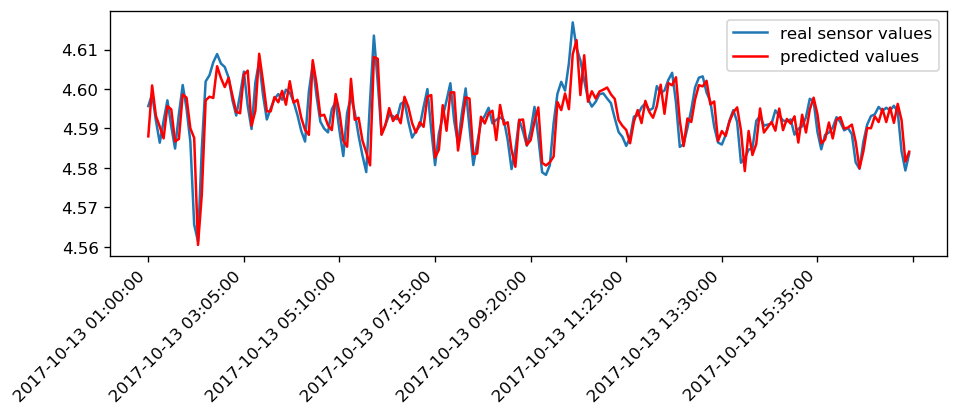

<Figure size 2400x1800 with 0 Axes>

In [158]:
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import MaxNLocator
fig, ax = pyplot.subplots()
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot

pyplot.figure(figsize = [20,15])
ax.plot(tl, test,  label='real sensor values')
ax.plot(tl, predictions, color='red',  label='predicted values')
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)



In [177]:

def mean_absolute_percentage_error(y_true, y_pred): 
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [181]:
pred = np.asarray(predictions)
pred = pred.reshape(200)


In [182]:
mean_absolute_percentage_error(test, pred)

0.07168125442639664

In [193]:
def absolute_percentage_error(y_true, y_pred): 
    return ((y_true - y_pred) / y_true)*100
error = absolute_percentage_error(test, pred)
error

array([ 0.16670933, -0.0480806 , -0.02654086, -0.08834392,  0.09637298,
        0.03175785, -0.09348576, -0.03914464,  0.13601673,  0.05229951,
       -0.0598558 , -0.07466166, -0.48057799,  0.01914721,  0.2543321 ,
        0.10422586,  0.1179969 ,  0.19657451,  0.06682184,  0.08001635,
        0.11039901,  0.00177294, -0.0245086 , -0.0201966 ,  0.10121865,
        0.01669139, -0.19383016, -0.01800043,  0.15629221, -0.04209249,
       -0.07486123, -0.04467178,  0.01527338, -0.01101783,  0.04513775,
       -0.0491725 ,  0.08253739, -0.06205693,  0.00478316, -0.08310419,
       -0.07298204, -0.06406473,  0.23883886, -0.02200189, -0.06697467,
       -0.03205751, -0.0761562 , -0.03957129,  0.11484535, -0.04327173,
       -0.09902916, -0.08492311,  0.18719471, -0.09888151,  0.04140744,
       -0.09916854, -0.08294186, -0.1093976 ,  0.35755912,  0.11671381,
       -0.12854044,  0.0039121 ,  0.00303321, -0.03800985,  0.0269402 ,
       -0.02242346,  0.10660719, -0.02660566, -0.07979052, -0.07

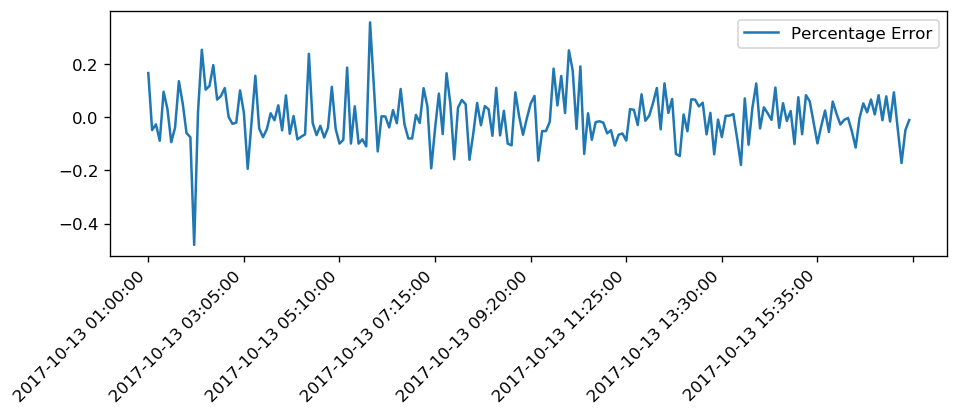

<Figure size 2400x1800 with 0 Axes>

In [194]:
fig, ax = pyplot.subplots()
pyplot.figure(figsize = [20,15])
ax.plot(tl, error,  label='Percentage Error')
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
fig.autofmt_xdate(rotation=45)
pyplot.show()
